In [303]:
import numpy as np
from map_utils import bresenham2D, mapCorrelation
import pandas as pd
import cv2
from matplotlib import pyplot as plt

## Load Datasets

In [624]:
dataset = 20

with np.load("Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans
    
with np.load("Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # Accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

## Preprocess Data

In [625]:
lidar_data = np.vstack([lidar_ranges,lidar_stamps])

In [626]:
# 
e_s = encoder_stamps.shape[0]
l_s = lidar_stamps.shape[0]
i_s = imu_stamps.shape[0]
li = np.concatenate([lidar_stamps.reshape([l_s,1]),np.zeros([l_s,1])],1)
en = np.concatenate([encoder_stamps.reshape([e_s,1]),np.ones([e_s,1])],1)

In [627]:
# [timestamp,type,index] 
li = np.concatenate([lidar_stamps.reshape([l_s,1]),np.zeros([l_s,1])],1)
li = np.concatenate([li,np.asarray(range(l_s)).reshape([l_s,1])],1)
en = np.concatenate([encoder_stamps.reshape([e_s,1]),np.ones([e_s,1])],1)
en = np.concatenate([en,np.asarray(range(e_s)).reshape([e_s,1])],1)
tot = np.vstack([li,en])
tot_sorted = tot[np.argsort(tot[:,0])]

In [628]:
tot_sorted.shape

(9918, 3)

## Motion Model

In [499]:
# combine imu and encoder data
control = np.zeros([e_s,6]) # [time, FR,FL,RR,RL,W]
control[:,0] = encoder_stamps
control[:,1:5] = np.transpose(encoder_counts)
for i in range(e_s):
    idx = np.argmin(abs(imu_stamps - encoder_stamps[i]))
    control[i,5] = imu_angular_velocity[2,idx]

def motion(X,t):
    '''Without noise, for dead reckoning'''
    # x = (x1,x2,theta)
    current = control[t]
    tau = control[t,0] - control[t-1,0]
    v_r = (current[1]+current[3])/2*0.0022/tau
    v_l = (current[2]+current[4])/2*0.0022/tau
    v = (v_r + v_l)/2
    omega = current[5]
    x1_new = tau * (v*np.sinc(omega*tau/2)*np.cos(X[2]+omega*tau/2))
    x2_new = tau * (v*np.sinc(omega*tau/2)*np.sin(X[2]+omega*tau/2))
    X[0] += x1_new
    X[1] += x2_new
    X[2] += tau * omega
    return X

def motion2(X,t):
    '''motion model with noise'''
    # x = (x1,x2,theta)
    current = control[t]
    tau = control[t,0] - control[t-1,0]
    v_r = (current[1]+current[3])/2*0.0022/tau
    v_l = (current[2]+current[4])/2*0.0022/tau
    v = (v_r + v_l)/2
    omega = current[5]
    x1_new = tau * (v*np.cos(X[2]))
    x2_new = tau * (v*np.sin(X[2]))
    X[0] += x1_new
    X[1] += x2_new
    X[2] += tau * omega
    noise = np.random.normal(0,1,3)
    X = X*(1+0.01*noise)
    return X

In [421]:
def yaw_to_R(yaw):
    R = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])
    return R

In [439]:
def dead(X):
    # init log odd map
    xy = update(X,0)
    cont = xy_to_grid(xy)
    map_min = -20
    map_max = 20
    grid_size = 0.05
    m_size = int((map_max - map_min) / grid_size)
    center = int(m_size/2)
    oc_grid = np.zeros([m_size,m_size])
    cv2.drawContours(oc_grid, cont, -1, (1,0,0), 3)
    log_map = np.log(oc_grid * (1/4-4) + 4)
    '''
    for t in range(1,tot_sorted.shape[0]):
        if tot_sorted[t,1] == 0 and tot_sorted[t,2]>0:
            # update
            idx_l = int(tot_sorted[t,2])
            xy = update(X,idx_l)
            cont = xy_to_grid(xy)
            oc_grid = np.zeros([m_size,m_size])
            cv2.drawContours(oc_grid, cont, -1, (1,0,0), 3)
            log_map += np.log(oc_grid * (1/4-4) + 4)
    '''
        elif tot_sorted[t,1] ==1:
            # move
            idx_m = int(tot_sorted[t,2])
            X = motion(X,idx_m)
    return log_map
            

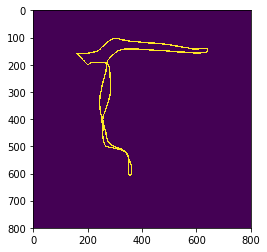

In [538]:
# Dead Reckoning
map_min = -10
map_max = 30
grid_size = 0.05
m_size = int((map_max - map_min) / grid_size)
center = int(-map_min/grid_size)
oc_grid = np.zeros([m_size,m_size])

cont = xy_grid(track[:,0:2])
a = np.transpose(cont).astype(int)
cv2.drawContours(oc_grid, [a], -1 ,(1,0,0), 3)
plt.imshow(oc_grid)

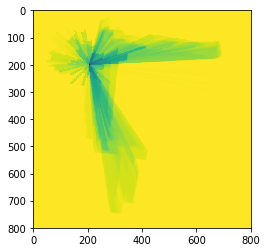

In [507]:
X = np.array([0.,0,0]).reshape([3,1])
ma = dead(X)
plt.imshow(ma)

## Update

In [575]:
def get_T(p,R):
    '''Get T matrix from p and R'''
    T = np.concatenate([R,p],1)
    T = np.concatenate([T, np.array([0,0,0,1]).reshape([1,4])])
    return T

def trans(xyz,T):
    '''transform vector using T matrix'''
    n = xyz.shape[0] # xyz: nx3
    s_old = np.transpose(np.concatenate([xyz,np.ones([n,1])],1))
    s_new = np.transpose(np.dot(T,s_old))
    xyz_new = s_new[:,:3]
    return xyz_new

def binary_map(log_map):
    '''convert log map to binary map'''
    pdf_map = 1-1/(1+np.exp(log_map)) # convert from log_map to pdf_map
    bin_map = np.rint(pdf_map) # round to binary map
    bin_map = bin_map.astype('int8')
    return bin_map

In [836]:
def trans(xyz,T):
    n = xyz.shape[0] # xyz: nx3
    s_old = np.transpose(np.concatenate([xyz,np.ones([n,1])],1))
    s_new = np.transpose(np.dot(T,s_old))
    xyz_new = s_new[:,:3]
    return xyz_new

def update(X,idx):
    p_lTr = np.array([0.30183,0,0.51435]).reshape([3,1])
    R_lTr = np.eye(3)
    p_rTw = np.array([X[0],X[1],0]).reshape([3,1])
    R_rTw = yaw_to_R(X[2])
    lid_range = lidar_ranges[:,idx].reshape([1081,1])
    angles = np.asarray(range(1081)).reshape([1081,1])
    angles = angles * lidar_angle_increment + lidar_angle_min # 1081 angles 
    lid_vals_0 = np.concatenate([lid_range,angles],axis = 1) # correspond range and angles
    # discard values too small/large
    lid_vals_1 = lid_vals_0[lid_vals_0[:,0]>= lidar_range_min]
    lid_vals = lid_vals_1[lid_vals_1[:,0] <= lidar_range_max]
    # (x,y,z) in lidar frame z=0
    xyz_lid = np.zeros([lid_vals.shape[0],3])
    xyz_lid[:,0] = lid_vals[:,0]*np.cos(lid_vals[:,1]) # x values
    xyz_lid[:,1] = lid_vals[:,0]*np.sin(lid_vals[:,1]) # y values
    T_lTr = get_T(p_lTr, R_lTr)
    T_rTw = get_T(p_rTw, R_rTw)
    # get_coordinate in robot frame 
    xyz_r = trans(xyz_lid,T_lTr)
    xyz_w = trans(xyz_r,T_rTw)
    p_lTw = trans(np.transpose(p_lTr),T_rTw)
    xy_w = xyz_w[:,:2]
    xy_w = xy_w.astype('float32')
    return xy_w

def xy_to_grid_new(xy):  
    # init map, unit meters
    map_min = -10
    map_max = 30
    grid_size = 0.05
    m_size = int((map_max - map_min) / grid_size)
    center = int(-map_min/grid_size)
    oc_grid = np.zeros([m_size,m_size])
    
    # lidar location in grid
    lid_x = p_lTw[0,0]
    lid_y = p_lTw[0,1]
    lid_x_g = lid_x//grid_size+center
    lid_y_g = lid_y//grid_size+center
    lid_g = np.asarray([lid_x_g,lid_y_g]).astype(int)
    
    grid_x = xy[:,0] //grid_size+center
    grid_y = xy[:,1] //grid_size+center
    grid_xy = np.vstack([grid_x,grid_y])
    
    cont = []
    for i in range(xy.shape[0]):
        line = np.array([lid_g,grid_xy[:,i].astype(int)])
        cont.append(line)
    cv2.drawContours(oc_grid, cont, -1, (1,0,0), 3)
    log_map = np.log(oc_grid * (1/9-9) + 9) #90% confident
    return log_map

def xy_to_grid(xy):  
    # init map, unit meters
    map_min = -10
    map_max = 30
    grid_size = 0.05
    m_size = int((map_max - map_min) / grid_size)
    center = int(-map_min/grid_size)
    oc_grid = np.zeros([m_size,m_size])
    
    # lidar location in grid
    lid_x = p_lTw[0,0]
    lid_y = p_lTw[0,1]
    lid_x_g = lid_x//grid_size+center
    lid_y_g = lid_y//grid_size+center
    lid_g = np.asarray([lid_x_g,lid_y_g]).astype(int)
    
    grid_x = xy[:,0] //grid_size+center
    grid_y = xy[:,1] //grid_size+center
    grid_xy = np.vstack([grid_x,grid_y])
    
    cont = []
    for i in range(xy.shape[0]):
        line = np.array([lid_g,grid_xy[:,i].astype(int)])
        cont.append(line)
    cv2.drawContours(oc_grid, cont, -1, (1,0,0), 1)
    log_map = np.log(oc_grid * (1/9-9) + 9) #90% confident
    return log_map

def get_log_map_new(X,idx):
    xy = update(X,idx)
    log_map = xy_to_grid_new(xy)
    return log_map

def get_log_map(X,idx):
    xy = update(X,idx)
    log_map = xy_to_grid(xy)
    return log_map

def correlate(X,idx,log_map):
    map_min = -10
    map_max = 30
    grid_size = 0.05
    m_size = int((map_max - map_min) / grid_size)
    center = int(-map_min/grid_size)
    x_im = np.arange(map_min,map_max +grid_size,grid_size) 
    y_im = np.arange(map_min,map_max +grid_size,grid_size) 
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    MAP = binary_map(log_map)
    vp = np.transpose(update(X,idx))
    c = mapCorrelation(MAP,x_im,y_im,vp,x_range,y_range)
    max_c = np.max(c)
    return max_c

def softmax(z):
    # z-max(z) version of softmax
    z_new = z-np.max(z)
    sum_z = np.sum(np.exp(z_new))
    exp_z = np.exp(z_new)
    result = exp_z / sum_z
    return result

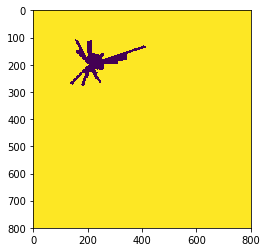

In [611]:
# initilaize map
X = np.array([0,0,0]).reshape([3,1])
m = get_log_map(X,0)
plt.imshow(m)

## Particle Filter

In [868]:
def pf(N):
    # init X, log odd map
    # number of particles N
    # init particles, log odd map
    #X = np.zeros([3,N])
    X = np.random.normal(0,0.1,[3,N])
    
    log_map = get_log_map_new(X[:,0],0)
    track = np.zeros([e_s,3,N])
    log_map_list = [log_map]
    #for t in range(1,r):
    for t in range(1,tot_sorted.shape[0]):
        if tot_sorted[t,1] == 0 and tot_sorted[t,2]>0:
            # update
            idx = int(tot_sorted[t,2])
            # for each particle:
            c = np.zeros(N) # for storing correlations
            for i in range(N):
                # current particle
                X_c = X[:,i]
                #get corr 
                c_c = correlate(X_c,idx,log_map)
                #print(c_c)
                c[i] = c_c
            weights = softmax(c)
            #print(weights)
            #update log_map
            idx_max = np.argmax(weights)
            log_add = get_log_map(X[:,idx_max],idx) # update using particle with largest weight
            log_map_new =log_map_list[-1] + log_add
            # constraint on log_odds:
            max_val = 2
            min_val = -5000
            log_map_new[log_map_new > max_val] = max_val
            log_map_new[log_map_new < min_val] = min_val
            # check for resampling
            #SIR
            thresh = int(N/4)
            N_eff = 1/np.sum(np.square(weights))
            if N_eff <= thresh:
                random_idx = np.random.randint(N, size=N)
                X_new = np.zeros(X.shape)
                X_new = X[:,random_idx]
                X = X_new
                weights = np.ones(N)/N
            log_map_list.append(log_map_new)
        elif tot_sorted[t,1] ==1 and tot_sorted[t,2]>0:
            # move
            idx = int(tot_sorted[t,2])
            for i in range(N):
                X_c = X[:,i]
                X[:,i] = motion2(X_c,idx)
                track[idx,:,i]=X[:,i]
    return log_map_list,track
            

In [647]:
def plot_track(t,n):
    map_min = -10
    map_max = 30
    grid_size = 0.05
    m_size = int((map_max - map_min) / grid_size)
    center = int(-map_min/grid_size)
    oc_grid = np.zeros([m_size,m_size])

    cont = xy_grid(t[:,0:2,n])
    a = np.transpose(cont).astype(int)
    cv2.drawContours(oc_grid, [a], -1 ,(1,0,0), 3)
    return oc_grid

In [ ]:
ma,t = pf(20)

In [ ]:
plt.imshow(ma[-1])

In [ ]:
plt.imshow(binary_map(ma[-1]))

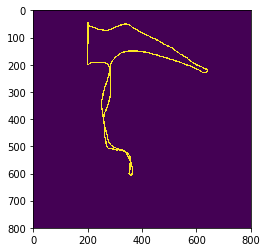

In [821]:
plt.imshow(plot_track(t,0))

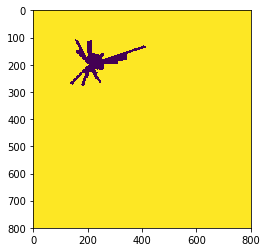

In [576]:
bin_map = binary_map(log_map)
plt.imshow(bin_map)